# Predicción del abandono (BURNOUT) de empleados

## Carga de los datos

El primer paso a seguir es cargar los datos para poder trabajar sobre ellos y construir un modelo que prediga si un empleado va a abandonar la empresa.

In [403]:
import pandas as pd

df = pd.read_pickle('attrition_available_12.pkl')
#value_counts

#jobINvolment = df['JobInvolvement']
#print(jobINvolment.value_counts())

## Análisis exploratorio de datos

Ver las primeras filas del dataframe para tener una idea de cómo están estructurados los datos.

In [404]:
df.head()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,7.315971,13.0,2.0,NaN,3.0,2.0,4.0,31.0,Yes,Travel_Frequently,...,0.0,Y,NaN,8.0,1.0,6.0,3,NaN,1.0,4.0
6,NaN,17.0,3.0,NaN,1.0,3.0,1.0,28.0,Yes,Travel_Rarely,...,2.0,Y,NaN,8.0,1.0,5.0,2,0.0,NaN,0.0
13,NaN,14.0,2.0,3.0,1.0,2.0,2.0,47.0,Yes,Non-Travel,...,1.0,Y,11.0,NaN,2.0,10.0,4,10.0,9.0,9.0
28,10.713066,6.0,2.0,3.0,4.0,NaN,1.0,NaN,Yes,NaN,...,3.0,Y,14.0,8.0,1.0,19.0,2,1.0,0.0,NaN
30,9.662808,NaN,2.0,3.0,1.0,2.0,3.0,26.0,Yes,Travel_Rarely,...,2.0,Y,11.0,8.0,0.0,5.0,5,3.0,0.0,2.0


Debemos tener en cuenta que lo que queremos predecir es la columna '`attrition`', que mide si el empleado va a dejar el trabajo o no.

Ver los tipos de datos de las columnas

In [405]:
df.dtypes

hrs                        float64
absences                   float64
JobInvolvement             float64
PerformanceRating          float64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                        float64
Attrition                   object
BusinessTravel              object
Department                  object
DistanceFromHome             int64
Education                  float64
EducationField              object
EmployeeCount              float64
EmployeeID                 float64
Gender                      object
JobLevel                     int64
JobRole                     object
MaritalStatus               object
MonthlyIncome              float64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike          float64
StandardHours              float64
StockOptionLevel           float64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany      

Contar el número de instancias y columnas

In [406]:
num_instances = len(df)
num_columns = len(df.columns)

print("Número de instancias: ", num_instances)
print("Número de columnas: ", num_columns)

Número de instancias:  4410
Número de columnas:  31


Ver si hay columnas constantes

In [407]:
const_cols = [col for col in df.columns if df[col].nunique() == 1]
print("Columnas constantes: ", const_cols)


Columnas constantes:  ['EmployeeCount', 'Over18', 'StandardHours']


Hemos visto que las columnas constantes son las siguientes: *EmployeeCount, Over18, StandardHours*. Ya que estas columnas no van a aportar ninguna información útil al modelo, debemos eliminarlas. Ahora en vez de 31 columnas, tendremos 28.

In [408]:
df = df.drop(const_cols, axis=1)

In [409]:
df = df.drop('EmployeeID', axis=1)

Volvemos a mirar el numero de instancias y columnas

In [410]:
num_instances = len(df)
num_columns = len(df.columns)

print("Número de instancias: ", num_instances)
print("Número de columnas: ", num_columns)

Número de instancias:  4410
Número de columnas:  27


Ver los valores de las columnas constantes

In [411]:
missing_vals = df.isnull().sum() / len(df)
print("Proporción de valores faltantes: ")
print(missing_vals)

Proporción de valores faltantes: 
hrs                        0.211791
absences                   0.213152
JobInvolvement             0.169388
PerformanceRating          0.193197
EnvironmentSatisfaction    0.209524
JobSatisfaction            0.170522
WorkLifeBalance            0.008617
Age                        0.211791
Attrition                  0.000000
BusinessTravel             0.172336
Department                 0.186395
DistanceFromHome           0.000000
Education                  0.218594
EducationField             0.180952
Gender                     0.200454
JobLevel                   0.000000
JobRole                    0.216780
MaritalStatus              0.202041
MonthlyIncome              0.192517
NumCompaniesWorked         0.166440
PercentSalaryHike          0.209524
StockOptionLevel           0.170748
TotalWorkingYears          0.186848
TrainingTimesLastYear      0.000000
YearsAtCompany             0.172336
YearsSinceLastPromotion    0.183447
YearsWithCurrManager       0.1

## Preprocesamiento de los datos

En esta sección realizaremos el procesamiento de los valores faltantes y la transformación de los datos categóricos.

Parae ello, primero realizaremos la división de los datos en un conjunto de entrenamiento y test

In [412]:
from sklearn.model_selection import train_test_split
from sklearn import set_config


X = df.drop('Attrition', axis=1) 
y = df['Attrition']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0, stratify=y)
set_config(transform_output="pandas")


Para transformar los valores categóricos en numéricos, utilizaremos la técnica One hot encoding.

In [413]:
# import pandas as pd


# # seleccionar la columna que quieres codificar
# column_to_encode = ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

# # aplicar One Hot Encoding
# one_hot_encoded = pd.get_dummies(df[column_to_encode])

# # combinar el nuevo DataFrame codificado con el original
# df_encoded = pd.concat([df, one_hot_encoded], axis=1)

# # eliminar la columna original
# df_encoded.drop(column_to_encode, axis=1, inplace=True)

# # mostrar el nuevo DataFrame codificado
# df_encoded.head()


In [414]:

# import numpy as np

# # Supongamos que la columna 0 contiene las variables categóricas que queremos convertir a numéricas
# categorical_cols = [0]  

# # Creamos una instancia de OneHotEncoder y especificamos las columnas que queremos codificar
# encoder = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
# encoder.fit(df[:, categorical_cols])

# # Transformamos las variables categóricas en variables numéricas
# encoded = encoder.transform(df[:, categorical_cols])

# # Concatenamos las variables numéricas con las demás columnas del conjunto de datos
# data_encoded = np.concatenate([df[:, :categorical_cols[0]], encoded, df[:, categorical_cols[0]+1:]], axis=1)


A continuación, se procederá a transformar los datos

In [415]:
# Primero importamos las librerías necesarias
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


# Definimos las columnas que son numéricas y las que son categóricas
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

# Imprimimos cuñales de estas columnas son numéricas y cuáles categóricas
print(f"Columnas numéricas: {list(numerical_features)}")
print(f"Columnas categóricas: {list(categorical_features)}")


# Definimos las transformaciones que se aplicarán a las columnas numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# Definimos las transformaciones que se aplicarán a las columnas categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(categories='auto', sparse_output=False, handle_unknown='ignore'))
])


# Pre-procesador "global"
processor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


processor.fit(X_train)
# Realizamos la transformación.
X_train_processed = processor.fit_transform(X_train)
X_test_processed = processor.transform(X_test)
X_train_processed.head()


Columnas numéricas: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Columnas categóricas: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']


,num__hrs,num__absences,num__JobInvolvement,num__PerformanceRating,num__EnvironmentSatisfaction,num__JobSatisfaction,num__WorkLifeBalance,num__Age,num__DistanceFromHome,num__Education,...,cat__JobRole_Laboratory Technician,cat__JobRole_Manager,cat__JobRole_Manufacturing Director,cat__JobRole_Research Director,cat__JobRole_Research Scientist,cat__JobRole_Sales Executive,cat__JobRole_Sales Representative,cat__MaritalStatus_Divorced,cat__MaritalStatus_Married,cat__MaritalStatus_Single
4282,7.608976,12.0,2.72938,3.0,2.730659,3.000000,3.0,43.0,2.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3087,6.178723,12.0,3.00000,3.0,1.000000,2.722563,3.0,25.0,5.0,2.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3130,7.311617,16.0,3.00000,3.0,2.000000,3.000000,3.0,40.0,15.0,2.907374,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2237,9.617732,2.0,3.00000,3.0,4.000000,3.000000,3.0,24.0,5.0,2.907374,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2559,7.311617,18.0,1.00000,3.0,2.730659,4.000000,2.0,36.0,5.0,3.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Comprobamos si se ha hecho bien y no hay missing values. Como se puede comprobar, se han transformado los datos de manera satisfactoria y ya no hay missing values y todos los datos se han convertido a numéricos mediante el uso de la técnica `OneHotEnconding`.

In [416]:
print(f"Numero de valores valtantes de entrenamiento: {np.isnan(X_train_processed).sum()}")
print(f"Numero de valores valtantes de test: {np.isnan(X_test_processed).sum()}")

Numero de valores valtantes de entrenamiento: num__hrs                                  0
num__absences                             0
num__JobInvolvement                       0
num__PerformanceRating                    0
num__EnvironmentSatisfaction              0
num__JobSatisfaction                      0
num__WorkLifeBalance                      0
num__Age                                  0
num__DistanceFromHome                     0
num__Education                            0
num__JobLevel                             0
num__MonthlyIncome                        0
num__NumCompaniesWorked                   0
num__PercentSalaryHike                    0
num__StockOptionLevel                     0
num__TotalWorkingYears                    0
num__TrainingTimesLastYear                0
num__YearsAtCompany                       0
num__YearsSinceLastPromotion              0
num__YearsWithCurrManager                 0
cat__BusinessTravel_Non-Travel            0
cat__BusinessTravel_Travel_Fre

## Balanceamiento de la clase   

Para saber si el conjunto de datos está desbalanceado, primeramente contaremos el número de observaciones en cada clase de la variable objetivo

In [417]:
# Contar el número de observaciones en cada clase de la variable objetivo
counts = df['Attrition'].value_counts()

print(counts)

No     3699
Yes     711
Name: Attrition, dtype: int64


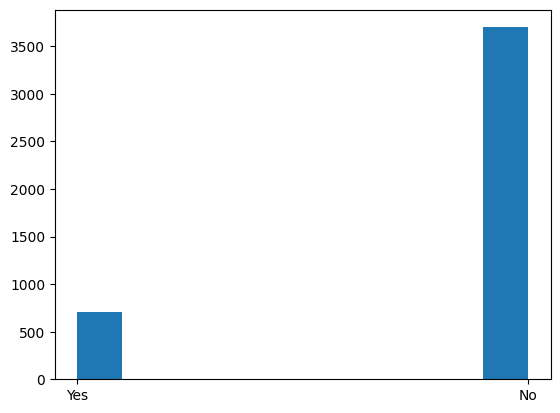

In [418]:
import matplotlib.pyplot as plt

# Crear un histograma de la variable objetivo
plt.hist(df['Attrition'])
plt.show()


Para estudiarlo más en profundidad, calculamos la proporción de observaciones en cada conjunto de entrenamiento y test.

In [419]:
N_SAMPLES_NEG = 3699
N_SAMPLES_POS = 711


In [420]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
# Vamos a comenzar realizando una división train/test "normal".
X_train_no_strat, X_test_no_strat, y_train_no_strat, y_test_no_strat = train_test_split(X, y, test_size=0.2)


# Comprobemos ahora la distribución de las clases.
n_pos_pct = N_SAMPLES_POS / (N_SAMPLES_POS + N_SAMPLES_NEG)
n_pos_train_pct = np.sum(y_train_no_strat=="Yes") / len(y_train_no_strat)
n_pos_test_pct = np.sum(y_test_no_strat=="Yes") / len(y_test_no_strat)

print(f"Hay un {100 * n_pos_train_pct:.1f} % de instancias positivas en train.")
print(f"Hay un {100 * n_pos_test_pct:.1f} % de instancias positivas en test.")
print(f"Hay un {100 * n_pos_pct:.1f} % de instancias positivas en total.")

Hay un 16.4 % de instancias positivas en train.
Hay un 15.0 % de instancias positivas en test.
Hay un 16.1 % de instancias positivas en total.


Basándonos en los resultados obtenidos, podemos afirmar que los datos están ligeramente desbalanceados. Al analizar la proporción de instancias positivas en el conjunto de train y test, observamos que esta proporción es de alrededor del 16%, lo que significa que la clase minoritaria está ligeramente subrepresentada, por lo que procedemos a hacer una `división estratificada`

Aunque en términos estrictos se puede considerar que los datos están desbalanceados, el desequilibrio no es extremo. En este caso, es posible que no se requieran técnicas de muestreo especializadas para equilibrar la distribución de clases y que un modelo de aprendizaje automático pueda entrenarse con éxito en este conjunto de datos.






In [421]:
# Ahora realizaremos una división estratificada.

# Comprobemos ahora la distribución de las clases.
n_pos_pct = N_SAMPLES_POS / (N_SAMPLES_POS + N_SAMPLES_NEG)
n_pos_train_pct = np.sum(y_train=="Yes") / len(y_train)
n_pos_test_pct = np.sum(y_test=="Yes") / len(y_test)

print(f"Hay un {100 * n_pos_train_pct:.1f} % de instancias positivas en train.")
print(f"Hay un {100 * n_pos_test_pct:.1f} % de instancias positivas en test.")
print(f"Hay un {100 * n_pos_pct:.1f} % de instancias positivas en total.")

Hay un 16.1 % de instancias positivas en train.
Hay un 16.1 % de instancias positivas en test.
Hay un 16.1 % de instancias positivas en total.


Y seguidamente, se realiza un proceso de validación cruzada estratificada

In [422]:
# Ahora vamos a realizar un proceso de validación cruzada estratificada.
cv = StratifiedKFold(n_splits=5)

n_fold = 1
for train_ix, test_ix in cv.split(X_train_strat, y_train_strat):
    y_train_train = y_train[train_ix]
    y_train_test = y_train[test_ix]
    n_pos_traintrain_pct = np.sum(y_train_train) / len(y_train_train)
    n_pos_traintest_pct = np.sum(y_train_test) / len(y_train_test)
    print(f"FOLD {n_fold}:")
    print(f"Hay un {100 * n_pos_traintrain_pct:.1f} % de instancias positivas en train-train.")
    print(f"Hay un {100 * n_pos_traintest_pct:.1f} % de instancias positivas en train-test.")
    n_fold += 1

KeyError: '[697, 704, 716, 727, 729, 730, 731, 732, 751, 752, 754, 756, 768, 770, 771, 774, 783, 786, 795, 802, 804, 812, 814, 822, 835, 838, 840, 842, 843, 850, 857, 862, 879, 881, 885, 887, 888, 890, 897, 899, 903, 905, 906, 907, 916, 920, 923, 927, 934, 940, 954, 958, 960, 962, 967, 969, 976, 978, 983, 990, 994, 1000, 1001, 1003, 1004, 1010, 1012, 1017, 1020, 1025, 1030, 1031, 1032, 1038, 1040, 1044, 1047, 1048, 1054, 1062, 1065, 1072, 1084, 1085, 1090, 1095, 1110, 1114, 1115, 1118, 1119, 1129, 1134, 1138, 1141, 1143, 1145, 1147, 1158, 1163, 1164, 1166, 1167, 1182, 1199, 1201, 1202, 1207, 1218, 1220, 1226, 1227, 1232, 1242, 1245, 1246, 1251, 1253, 1257, 1260, 1263, 1280, 1281, 1295, 1300, 1312, 1317, 1321, 1326, 1327, 1328, 1351, 1352, 1353, 1355, 1356, 1363, 1366, 1371, 1374, 1375, 1377, 1381, 1385, 1386, 1391, 1397, 1401, 1402, 1405, 1407, 1417, 1422, 1423, 1430, 1433, 1434, 1436, 1438, 1439, 1440, 1441, 1442, 1450, 1455, 1457, 1480, 1482, 1487, 1489, 1490, 1491, 1493, 1498, 1516, 1522, 1534, 1544, 1545, 1548, 1552, 1553, 1554, 1556, 1562, 1564, 1569, 1581, 1584, 1586, 1590, 1591, 1601, 1602, 1604, 1606, 1608, 1609, 1626, 1628, 1642, 1645, 1654, 1658, 1661, 1664, 1667, 1678, 1683, 1686, 1698, 1702, 1708, 1709, 1712, 1715, 1718, 1720, 1722, 1739, 1745, 1747, 1748, 1749, 1751, 1759, 1760, 1761, 1764, 1769, 1781, 1800, 1823, 1824, 1829, 1834, 1835, 1844, 1845, 1850, 1852, 1855, 1856, 1858, 1860, 1861, 1870, 1875, 1877, 1880, 1884, 1891, 1899, 1900, 1912, 1913, 1916, 1921, 1928, 1930, 1932, 1935, 1937, 1949, 1955, 1956, 1957, 1961, 1963, 1964, 1972, 1981, 1990, 1996, 1997, 2001, 2003, 2017, 2023, 2033, 2035, 2039, 2044, 2058, 2060, 2061, 2063, 2064, 2072, 2074, 2078, 2083, 2085, 2089, 2092, 2095, 2115, 2124, 2126, 2140, 2142, 2144, 2146, 2152, 2153, 2158, 2160, 2165, 2178, 2180, 2181, 2186, 2187, 2193, 2195, 2197, 2200, 2206, 2210, 2212, 2218, 2219, 2229, 2230, 2236, 2239, 2243, 2249, 2252, 2256, 2262, 2273, 2276, 2282, 2283, 2286, 2288, 2292, 2294, 2297, 2301, 2305, 2306, 2311, 2314, 2320, 2322, 2324, 2325, 2326, 2339, 2341, 2349, 2352, 2353, 2356, 2357, 2359, 2361, 2364, 2375, 2379, 2382, 2393, 2396, 2399, 2400, 2402, 2412, 2413, 2414, 2415, 2418, 2431, 2437, 2439, 2443, 2450, 2458, 2459, 2474, 2475, 2480, 2483, 2486, 2487, 2490, 2497, 2499, 2502, 2517, 2519, 2525, 2531, 2534, 2535, 2544, 2554, 2558, 2560, 2567, 2571, 2573, 2575, 2581, 2582, 2586, 2587, 2591, 2594, 2596, 2598, 2601, 2603, 2607, 2608, 2610, 2613, 2614, 2615, 2623, 2625, 2642, 2645, 2649, 2650, 2651, 2654, 2669, 2673, 2680, 2686, 2692, 2695, 2697, 2707, 2708, 2713, 2718, 2722, 2725, 2738, 2742, 2744, 2750, 2769, 2782, 2783, 2785, 2788, 2790, 2796, 2804, 2807, 2818, 2820, 2830, 2834, 2842, 2843, 2846, 2847, 2848, 2850, 2853, 2865, 2867, 2880, 2881, 2886, 2890, 2896, 2900, 2904, 2909, 2914, 2917, 2937, 2942, 2946, 2947, 2954, 2971, 2976, 2979, 2983, 2984, 2992, 2997, 3012, 3021, 3031, 3032, 3035, 3044, 3051, 3052, 3060, 3075, 3084, 3089, 3093, 3097, 3099, 3105, 3108, 3117, 3122, 3137, 3148, 3151, 3153, 3154, 3155, 3161, 3169, 3170, 3175, 3177, 3182, 3188, 3191, 3193, 3197, 3198, 3199, 3201, 3208, 3217, 3228, 3229, 3230, 3239, 3241, 3248, 3250, 3253, 3260, 3264, 3266, 3268, 3272, 3274, 3275, 3279, 3284, 3285, 3292, 3295, 3297, 3305, 3308, 3312, 3313, 3316, 3317, 3330, 3344, 3347, 3352, 3353, 3357, 3364, 3366, 3367, 3372, 3378, 3384, 3398, 3399, 3400, 3403, 3410, 3415, 3419, 3426, 3436, 3437, 3438, 3440, 3451, 3455, 3456, 3457, 3458, 3460, 3461, 3465, 3466, 3470, 3483, 3486, 3494, 3501, 3505, 3508, 3509, 3520, 3524] not in index'